In [364]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



In [337]:
df = pd.read_csv("./data/data.csv")

## Описание колонок

Author -  может быть указано имя исследователя или исследовательской группы, которые проводили эксперимент или собирали данные.

Geometry - тип геометрии, используемой в эксперименте, например, труба или кольцевое пространство.

Pressure [МПа] -  давление жидкости в эксперименте, измеренное в мегапаскалях.

Mass_flux [кг / м2-с] - массовый поток жидкости в эксперименте, измеренный в килограммах на квадратный метр в секунду.

D_e [мм] - эквивалентный диаметр экспериментальной геометрии, измеренный в миллиметрах.

D_h [мм] - гидравлический диаметр экспериментальной геометрии, измеренный в миллиметрах.

Длина [мм] - длина экспериментальной геометрии, измеряемая в миллиметрах.

Chf_exp [МВт / м2] - экспериментальный критический тепловой поток, измеренный в мегаваттах на квадратный метр.

X_e_out [-] (target) - Этот столбец представляет переменную, связанную с качеством жидкости на выходе в эксперименте.


In [338]:
df.rename(columns={'pressure [MPa]':'pressure',
                       'mass_flux [kg/m2-s]':'mass_flux',
                       'x_e_out [-]':'x_e_out', 
                       'D_e [mm]':'D_e', 
                       'D_h [mm]':'D_h', 
                       'length [mm]':'length',
                       'chf_exp [MW/m2]':'chf_exp'}, inplace=True)

In [ ]:
df.describe()

,id,pressure,mass_flux,x_e_out,D_e,D_h,length,chf_exp
count,31644.000000,27192.000000,26853.000000,21229.000000,26156.000000,27055.000000,26885.000000,31644.000000
mean,15821.500000,10.640747,3068.011023,-0.000453,8.629255,14.174330,832.987391,3.796985
std,9134.980296,4.333683,1777.032080,0.100911,5.185692,19.838489,672.299239,1.983991
min,0.000000,0.100000,0.000000,-0.866700,1.000000,1.000000,10.000000,0.800000
25%,7910.750000,6.890000,1519.000000,-0.046600,5.000000,5.600000,318.000000,2.400000
50%,15821.500000,11.070000,2731.000000,0.003800,7.800000,10.000000,610.000000,3.400000
75%,23732.250000,13.790000,4069.000000,0.064800,10.800000,11.500000,914.000000,4.600000
max,31643.000000,20.680000,7975.000000,0.232000,37.500000,120.000000,3048.000000,19.300000


In [136]:
def get_df_info(df: pd.DataFrame, thr = 0.02, *args, **kwargs) -> pd.DataFrame:
    '''
    docstring example:

    Выводит инфу о колонках датафрейма в виде датафрейма

    df: исходный датафрейм
    ...

    returns: pd.DataFrame с инфой

    '''
    size = df.shape[0]
    new_df = pd.DataFrame(data=df.dtypes, index= df.columns, columns=['dtype'])

    new_df['nunique'] = df.nunique('index', dropna=False)

    new_df['zero'] = ((df == 0).sum() + (df =='0').sum())/size

    new_df['nan'] = df.isna().sum()/size

    new_df['empty_str'] = (df == '').sum()/size
	
	# цикл применяется к колонкам
    # df[x].value_counts(dropna=True).values[0] - подсчет количества каждого элемента в колонке
	#  в убывающем порядке
    # (df[x].count()) - rоличество не NaN элементов    
    new_df['vc_max_proportion'] = df.columns.map(lambda x: (df[x].value_counts(dropna=True).values[0]/df[x].count()).round(3))
    
    new_df['vc_max_value'] = df.columns.map(lambda x: df[x].value_counts().index[0])
    
    if df.where(df != '').dropna().shape[0] > 2:
        new_df['example_1'] = df.where(df != '').dropna().iloc[0]
        new_df['example_2'] = df.where(df != '').dropna().iloc[1]

    new_df['trash_score'] = new_df.vc_max_proportion
    new_df.loc[new_df.trash_score <= thr, 'trash_score'] = 0
    new_df.trash_score = np.max([(new_df.zero + new_df.nan + new_df.empty_str).values, new_df.trash_score.values], axis=0)

	# округляю ненулевые элементы до 3 знаков,
	# нулевые будут выглядеть как 0.0 - pаменяю их на '-1'
    new_df[new_df != 0] = new_df[new_df != 0].round(3)
    new_df = new_df.astype('string').replace('0.0', '-1')
    
    return new_df


get_df_info(df)

,dtype,nunique,zero,nan,empty_str,vc_max_proportion,vc_max_value,example_1,example_2,trash_score
id,int64,31644,-1,-1,-1,-1,31643,3,9,-1
author,object,11,-1,0.159,-1,0.653,Thompson,Beus,Peskov,0.653
geometry,object,4,-1,0.174,-1,0.809,tube,annulus,tube,0.809
pressure,float64,145,-1,0.141,-1,0.339,13.79,13.79,12.0,0.339
mass_flux,float64,734,-1,0.151,-1,0.036,4069.0,3679.0,1617.0,0.152
x_e_out,float64,1683,-1,0.329,-1,0.008,0.0334,-0.0279,0.1228,0.329
D_e,float64,44,-1,0.173,-1,0.103,10.3,5.6,10.0,0.173
D_h,float64,50,-1,0.145,-1,0.103,10.3,15.2,10.0,0.145
length,float64,71,-1,0.15,-1,0.118,457.0,2134.0,520.0,0.15
chf_exp,float64,109,-1,-1,-1,0.04,2.3,3.0,2.2,0.04


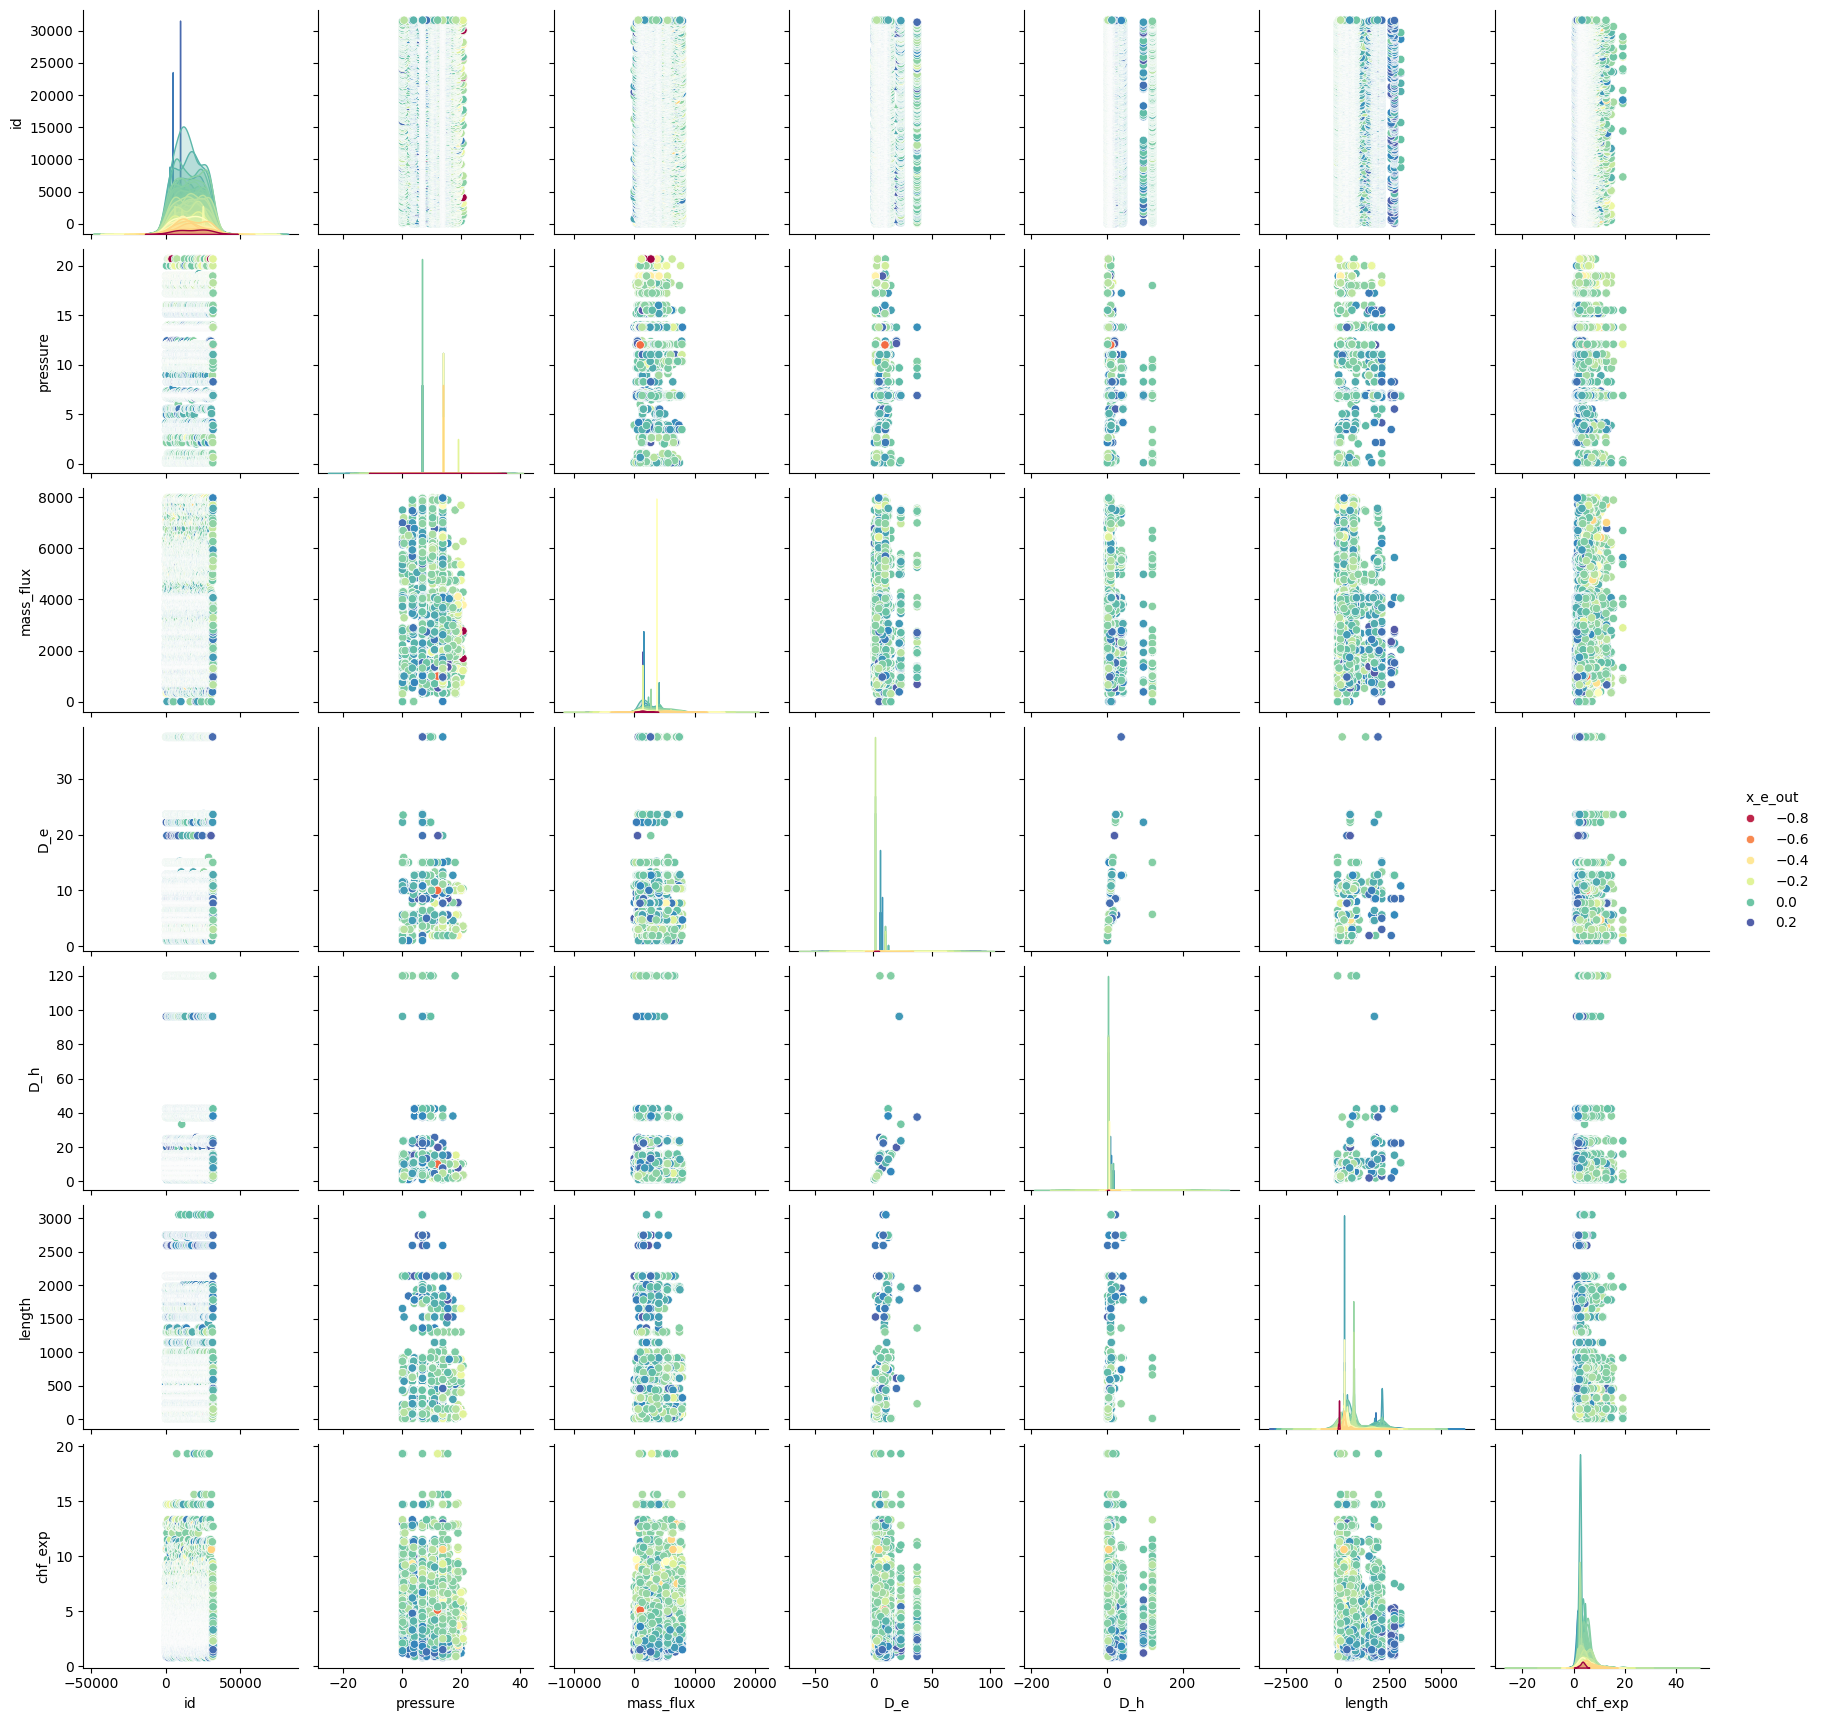

In [31]:
sns.pairplot(df[~df.x_e_out.isna()], hue='x_e_out', palette="Spectral")
plt.show()

In [339]:
X_train, y_train = df[~df.x_e_out.isna()][df.columns.drop('x_e_out')], df[~df.x_e_out.isna()]['x_e_out']
X_test, y_test = df[df.x_e_out.isna()][df.columns.drop('x_e_out')], df[df.x_e_out.isna()]['x_e_out']
print(y_train.shape, y_test.shape)

(21229,) (10415,)


In [340]:
numerical_features = df.select_dtypes(include=['number']).columns
categorial_features = df.columns.drop(numerical_features)
numerical_features = numerical_features.drop(['id', 'x_e_out'])

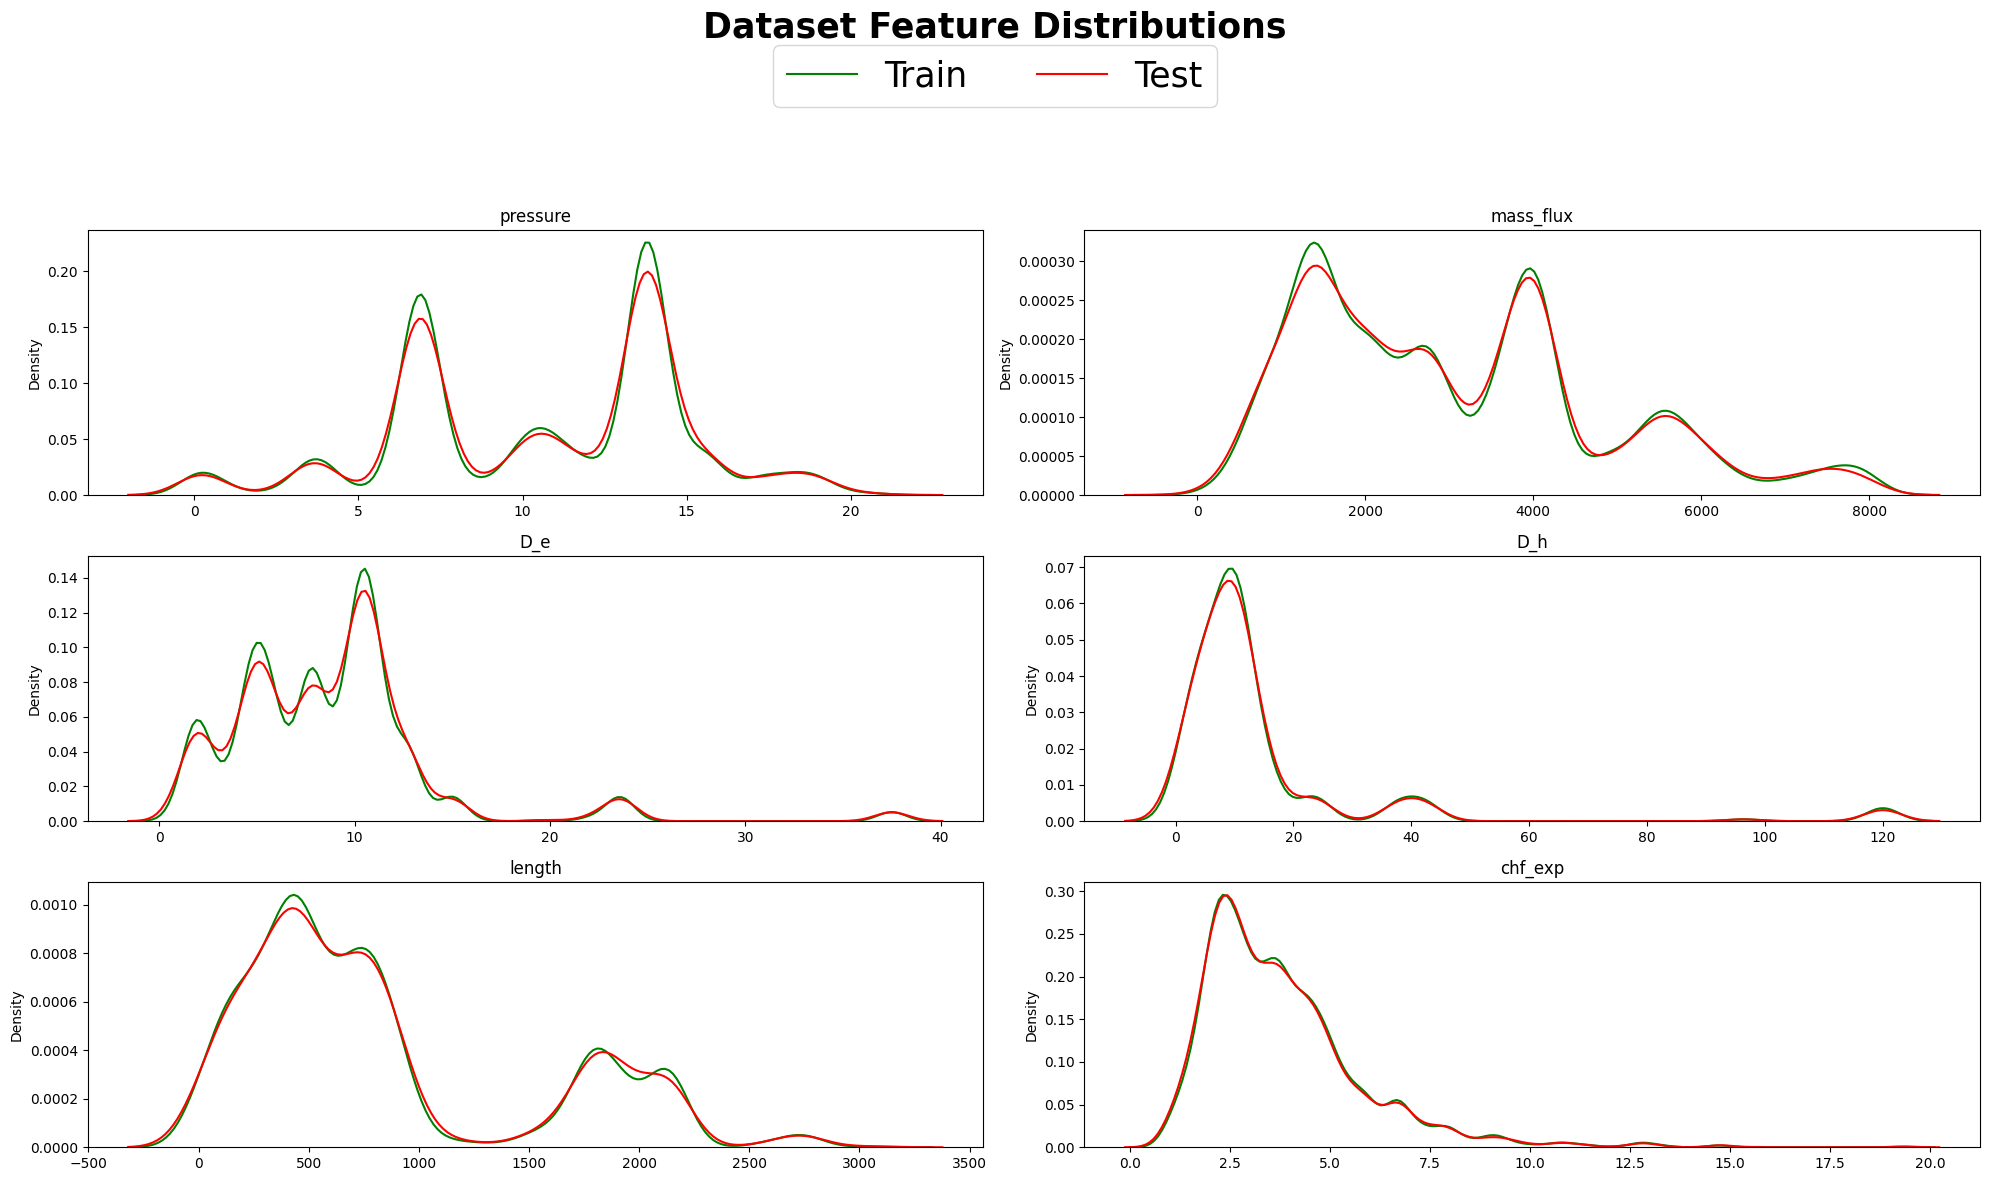

In [ ]:
import math
features = numerical_features
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 2
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        X_train[column], label='Train',
        ax=ax[i], color='g'
    )
    
    sns.kdeplot(
        X_test[column], label='Test',
        ax=ax[i], color='r'
    )

    # titles
    ax[i].set_title(f'{column}');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

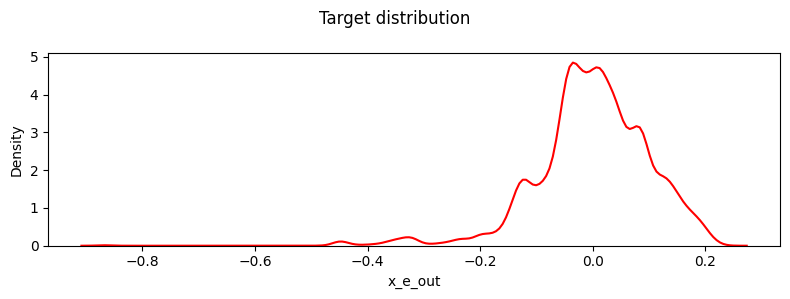

In [ ]:
fig = plt.figure(figsize=(8,3))
sns.kdeplot(y_train, label='Train distribution', color='r')
fig.suptitle(f'Target distribution')
plt.tight_layout()

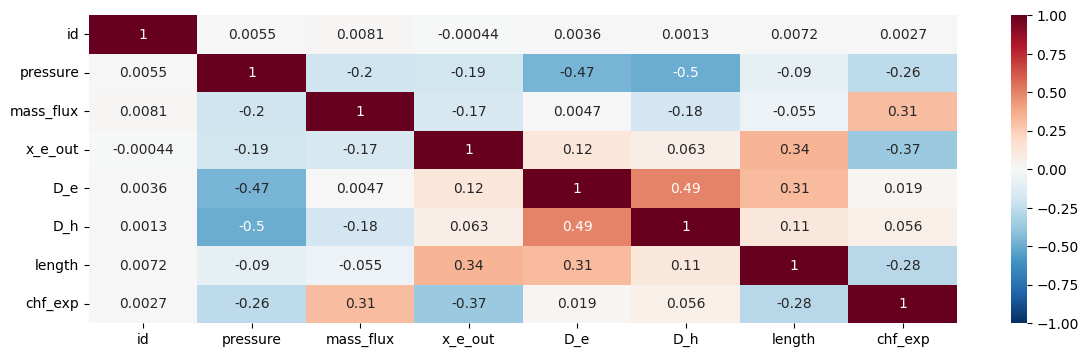

In [27]:
plt.figure(figsize=(14,4))
sns.heatmap(
    df[numerical_features].corr(),        
    cmap='RdBu_r',
    annot=True, 
    vmin=-1, vmax=1)
plt.show()

C:\Users\mmkorshunova\AppData\Local\Temp\ipykernel_13008\412407186.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(pd.unique(df[col]), rotation=45, ha='right')


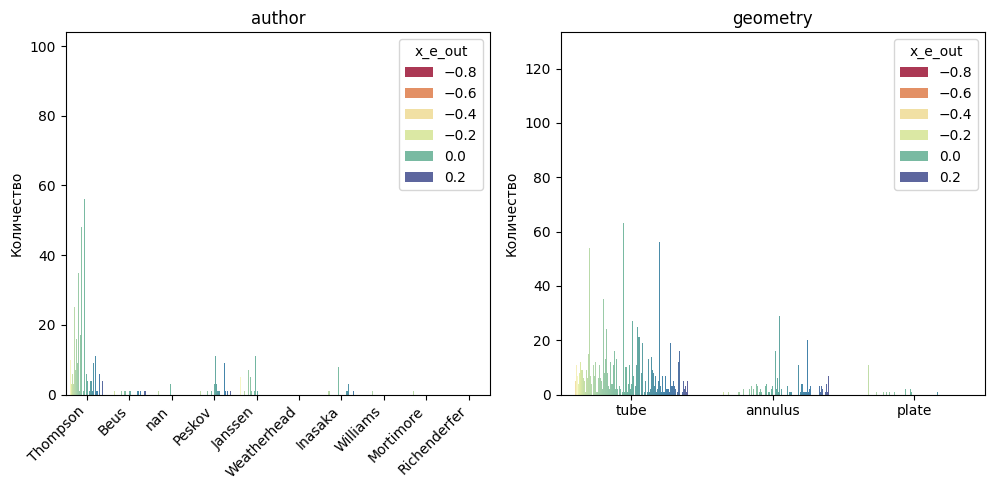

In [30]:
# Строим сетку гистограмм
num_cols = len(categorial_features)
num_rows = (num_cols + 1) // 2 

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows)) # создаем сетку графиков
axes = axes.flatten() 
for i, col in enumerate(categorial_features):
  sns.countplot(x=col, data=df, ax=axes[i], hue='x_e_out', palette="Spectral") 
  axes[i].set_title(f'{col}')
  axes[i].set_ylabel('Количество')
  axes[i].set_xlabel('')
  if df[col].nunique() > 5:
    axes[i].set_xticklabels(pd.unique(df[col]), rotation=45, ha='right')


# Удаляем лишние оси, если их количество больше, чем количество признаков
for i in range(len(categorial_features), len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout() 
plt.show()


## NaN's

### categorial features

In [196]:
X_train[(X_train.geometry.isna()) & (X_train.author.isna())].shape[0]/X_train.shape[0]

0.028169014084507043

In [341]:
def fillna_for_cat_features(data):
    for col in categorial_features:
        data[col+'_is_NA'] = np.where(data[col].isna(), 1, 0)
        
    data['author'] = data['author'].fillna(data['author'].mode()[0]) 

    mode_by_author = data.groupby('author')['geometry'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    data['geometry'] = data['geometry'].fillna(data['author'].map(mode_by_author))

    return data[categorial_features].isna().sum()

fillna_for_cat_features(X_train)

author      0
geometry    0
dtype: int64

In [299]:
X_train.head()

,id,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA
0,0,Thompson,tube,7.00,3770.0,NaN,10.8,432.0,3.6,0,0
1,1,Thompson,tube,NaN,6049.0,10.3,10.3,762.0,6.2,0,0
2,2,Thompson,tube,13.79,2034.0,7.7,7.7,457.0,2.5,0,1
3,3,Beus,annulus,13.79,3679.0,5.6,15.2,2134.0,3.0,0,0
5,5,Thompson,tube,17.24,3648.0,NaN,1.9,696.0,3.6,1,1


### numerical features

In [342]:
def fillna_for_num_features(data):
    for col in numerical_features:
        if data[col].isnull().sum() > 0:
            mode_by_geometry = data.groupby('geometry')[col].apply(lambda x: x.mean())
            data[col] = data[col].fillna(data['geometry'].map(mode_by_geometry))

    return data[numerical_features].isna().sum()

fillna_for_num_features(X_train)

pressure     0
mass_flux    0
D_e          0
D_h          0
length       0
chf_exp      0
dtype: int64

In [301]:
X_train.head()

,id,author,geometry,pressure,mass_flux,D_e,D_h,length,chf_exp,author_is_NA,geometry_is_NA
0,0,Thompson,tube,7.000000,3770.0,8.386172,10.8,432.0,3.6,0,0
1,1,Thompson,tube,11.157708,6049.0,10.300000,10.3,762.0,6.2,0,0
2,2,Thompson,tube,13.790000,2034.0,7.700000,7.7,457.0,2.5,0,1
3,3,Beus,annulus,13.790000,3679.0,5.600000,15.2,2134.0,3.0,0,0
5,5,Thompson,tube,17.240000,3648.0,8.386172,1.9,696.0,3.6,1,1


In [343]:
X_train.isna().sum()

id                0
author            0
geometry          0
pressure          0
mass_flux         0
D_e               0
D_h               0
length            0
chf_exp           0
author_is_NA      0
geometry_is_NA    0
dtype: int64

In [344]:
fillna_for_cat_features(X_test)
fillna_for_num_features(X_test)
X_test.isna().sum()

id                0
author            0
geometry          0
pressure          0
mass_flux         0
D_e               0
D_h               0
length            0
chf_exp           0
author_is_NA      0
geometry_is_NA    0
dtype: int64

In [ ]:
ohe = OneHotEncoder()

train_encoded = ohe.fit_transform(X_train[categorial_features])
test_encoded = ohe.transform(X_test[categorial_features])

encoded_cols = ohe.get_feature_names_out(categorial_features)

X_train_cat_encoded = pd.DataFrame(train_encoded.toarray(), columns=encoded_cols, index=X_train.index)
X_test_cat_encoded = pd.DataFrame(test_encoded.toarray(), columns=encoded_cols, index=X_test.index)

X_train = pd.concat([X_train, X_train_cat_encoded], axis=1).drop(columns=categorial_features)
X_test = pd.concat([X_test, X_test_cat_encoded], axis=1).drop(columns=categorial_features)


## Model

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [408]:
linespace = pd.Index(range(X_train.index[-1]))
test_indexes = linespace[~linespace.isin(X_train.index)]
y_test_pred = pd.DataFrame(data={'id': test_indexes, 'x_e_out [-]': y_pred}, index=test_indexes)
y_test_pred.to_csv('submission.csv', index=False)